# Comparing the output distirbutions of different Generative Methods

In [1]:
import torch
import numpy as np
import normflows as nf
import os

from matplotlib import pyplot as plt

from tqdm import tqdm

from jet_dataset import JetDataset
from script_jets import DDPM, SimpleCondFF

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
###################################
### Define the Normalizing Flow ###
###################################

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16

ep = 7499
flow_dir = './data/NF_2_jets15/'

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
flow = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
flow = flow.to(device)
flow.eval()

flow.load_state_dict(torch.load(flow_dir + f"model_{ep}.pth"))
print('loaded model from ' + flow_dir + f"model_{ep}.pth")

loaded model from ./data/NF_2_jets15/model_7499.pth


In [4]:
###########################################################
### Define the Normalizing Flow trained on reduced data ###
###########################################################

del_context_1 = ['label_top']

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16 - len(del_context_1)

ep = 5000
flow_dir = './data/NF_jets15_label_top/'

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0_1 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
flow_1 = nf.ConditionalNormalizingFlow(q0_1, flows)

# Move model on GPU if available
flow_1 = flow_1.to(device)
flow_1.eval()

flow_1.load_state_dict(torch.load(flow_dir + f"model_{ep}.pth"))
print('loaded model from ' + flow_dir + f"model_{ep}.pth")

loaded model from ./data/NF_jets15_label_top/model_5000.pth


In [5]:
############################################################
### Define the Normalizing Flow trained on only jet data ###
############################################################

del_context_2 = ['label_top', 'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt',	'aux_truth_match']

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16 - len(del_context_2)

ep = 5000
flow_dir = './data/NF_jets15_label_top_aux_genpart_eta_aux_genpart_phi_aux_genpart_pid_aux_genpart_pt_aux_truth_match/'

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0_2 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
flow_2 = nf.ConditionalNormalizingFlow(q0_2, flows)

# Move model on GPU if available
flow_2 = flow_2.to(device)
flow_2.eval()

flow_2.load_state_dict(torch.load(flow_dir + f"model_{ep}.pth"))
print('loaded model from ' + flow_dir + f"model_{ep}.pth")

loaded model from ./data/NF_jets15_label_top_aux_genpart_eta_aux_genpart_phi_aux_genpart_pid_aux_genpart_pt_aux_truth_match/model_5000.pth


In [6]:
##################################
### Define the Diffusion Model ###
##################################

n_classes = 10 #have no effect
n_feat = 256 # 128 ok, 256 better (but slower)
n_T = 400 # probably total overkill

ep = 59
diff_dir = './data/diffusion_jets15_great/'

nn_model_class = SimpleCondFF #ContextUnet

ddpm = DDPM(nn_model=nn_model_class(in_channels=1, 
                                    n_feat=n_feat, 
                                    n_classes=n_classes), 
                                    betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.eval()

ddpm.load_state_dict(torch.load(diff_dir + f"model_{ep}.pth"))
print('loaded model from ' + diff_dir + f"model_{ep}.pth")

loaded model from ./data/diffusion_jets15_great/model_59.pth


In [7]:
#######################
### Define the data ###
#######################

['label_top' 'jet_pt' 'jet_eta' 'jet_phi' 'jet_energy' 'jet_nparticles'
 'jet_sdmass' 'jet_tau1' 'jet_tau2' 'jet_tau3' 'jet_tau4'
 'aux_genpart_eta' 'aux_genpart_phi' 'aux_genpart_pid' 'aux_genpart_pt'
 'aux_truth_match']
1.0
1.0
1.0


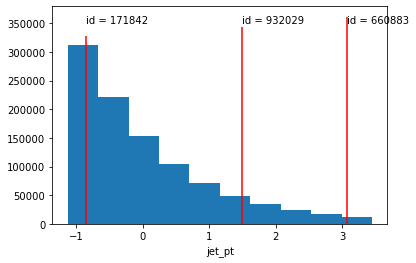

In [16]:
##################################################
### get validation from the distribution tails ###
##################################################

dataset_val = JetDataset("./jet_data", 'val')
labels = np.array(dataset_val.data.keys())[2:]

print(labels)

plt.hist(dataset_val.features[:,1])
plt.xlabel(labels[1])


sort = np.argsort(dataset_val.features[:,1])
for i in [200003, -100005, -10000]:
    plt.vlines(dataset_val.features[sort[i],1], *plt.ylim(), color = 'red', label='target')
    plt.text(dataset_val.features[sort[i],1], 350000, f'id = {sort[i]}')
    print(dataset_val.features[sort[i],0])

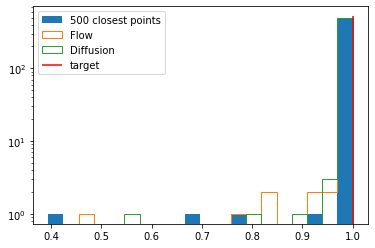

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/bierings/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-f00275d0e513>", line 51, in <module>
    plt.savefig(f'./out_{i}.pdf')
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/pyplot.py", line 979, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/figure.py", line 3046, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 2325, in print_figure
    **kwargs)
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1648, in wrapper
    return func(*args, **kwargs)
  File "/beegfs/desy/user/bie

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/bierings/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-f00275d0e513>", line 51, in <module>
    plt.savefig(f'./out_{i}.pdf')
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/pyplot.py", line 979, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/figure.py", line 3046, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 2325, in print_figure
    **kwargs)
  File "/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1648, in wrapper
    return func(*args, **kwargs)
  File "/beegfs/desy/user/bie

TypeError: object of type 'NoneType' has no len()

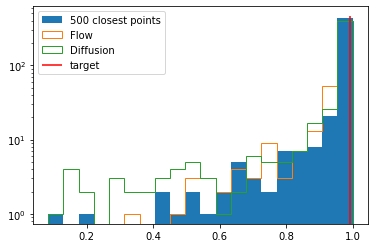

In [8]:
n_plot = 500
n_stat_alea = 500


for i in [5, 801, -100]:
    dataset_train = JetDataset("./jet_data", 'train')
    conditions_train = np.array(dataset_train.features)

    dataset_val = JetDataset("./jet_data", 'val')
    conditions = np.array(dataset_val.features)

    dist_tmp = np.sqrt(np.sum(((conditions_train-conditions[i])**2), axis=1))
    sort = np.argsort(dist_tmp)
    x_data = torch.Tensor(dataset_train.target[sort[:n_plot]]*20)
    _,b,_ = plt.hist(torch.sigmoid(x_data).numpy(), bins = 20, label = f'{n_plot} closest points')
    del dataset_train, conditions_train

    dataset_val = JetDataset("./jet_data",'val')
    conditions = torch.Tensor(dataset_val.features).to(device)
    #bins = np.linspace(-20,20,40)

    x_gen_flow, _ = flow.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))
    x_gen_flow = torch.sigmoid(20*x_gen_flow)
    _,b,_ = plt.hist(x_gen_flow.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Flow')
    del x_gen_flow

    x_gen_diff, _ = ddpm.sample(conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0), device = device)
    x_gen_diff = torch.sigmoid(20*x_gen_diff)
    plt.hist(x_gen_diff.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Diffusion')
    del x_gen_diff

    # dataset_val = JetDataset("./jet_data",'val', del_context=del_context_1)
    # conditions = torch.Tensor(dataset_val.features).to(device)
    # x_gen_flow, _ = flow_1.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))
    # x_gen_flow *= 20
    # _,b,_ = plt.hist(x_gen_flow.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Flow w/o truth')
    # del x_gen_flow
    
    # dataset_val = JetDataset("./jet_data",'val', del_context=del_context_2)
    # conditions = torch.Tensor(dataset_val.features).to(device)
    # x_gen_flow, _ = flow_2.sample(1*n_stat_alea, context=conditions[i:i+1].repeat_interleave(n_stat_alea, dim=0))
    # x_gen_flow *= 20
    # _,b,_ = plt.hist(x_gen_flow.detach().cpu().numpy(), bins = b, histtype = 'step', label = 'Flow only jet')
    # del x_gen_flow

    x_target = torch.Tensor(dataset_val.target[i:i+1]*20)
    plt.vlines(torch.sigmoid(x_target).numpy(), *plt.ylim(), color = 'red', label='target')
    del dataset_val
    plt.yscale('log')
    plt.legend()
    plt.savefig(f'./out_{i}.pdf')
    plt.show()

In [ ]:
#plot over input bins

n_bins = 5
dataset_train = JetDataset("./jet_data",'train')
labels = np.array(dataset_train.data.keys())[2:]

fig, ax = plt.subplots(dataset_train.features.shape[1], n_bins, figsize = (2*n_bins, 2*dataset_train.features.shape[1]), sharex=True, sharey=True)

for i_f in range(dataset_train.features.shape[1]):
    print(i_f, end = '\r')
    bins = np.linspace(dataset_train.features[:,i_f].min(), dataset_train.features[:,i_f].max(), n_bins+1)

    for i_b in range(n_bins):

        mask = np.bitwise_and(dataset_train.features[:,i_f]>=bins[i_b], dataset_train.features[:,i_f]<=bins[i_b+1])
        ax[i_f,i_b].hist(dataset_train.target[mask]*20)
        ax[i_f,0].set_ylabel(labels[i_f])
        ax[i_f,i_b].set_title(f'[{bins[i_b]:3.2}, {bins[i_b+1]:3.2}]')

fig.subplots_adjust(wspace=0.)